# Modèle pour la détermination du type de véhicule

### 1. Préparation des données

Crop provisoire des images

In [89]:
import os
from PIL import Image

def crop_images (dossier_crops, dossier_coordonnees, dossier_images) :
    # Obtenir les listes triées des fichiers dans les dossiers
    fichiers_images = sorted(os.listdir(dossier_images))
    fichiers_coordonnees = sorted(os.listdir(dossier_coordonnees))

    # Vérifier si les deux dossiers ont le même nombre de fichiers
    if len(fichiers_images) != len(fichiers_coordonnees):
        print("Le nombre de fichiers dans les deux dossiers ne correspond pas.")
        exit()

    # Parcours des images et fichiers de coordonnées
    for index, image_file in enumerate(fichiers_images):
        if image_file.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(dossier_images, image_file)
            coord_file = os.path.join(dossier_coordonnees, fichiers_coordonnees[index])
            
            # Charger l'image
            with Image.open(image_path) as img:
                img_width, img_height = img.size  # Taille de l'image
                # Lire les coordonnées
                with open(coord_file, "r") as file:
                    lines = file.readlines()
                    for i, line in enumerate(lines):
                        data = line.strip().split()
                        
                        # Vérifier la validité des données
                        if len(data) < 9:
                            print(f"Coordonnées invalides dans {coord_file}, ligne {i + 1}")
                            continue

                        img_type = data[-2]

                        # Calcul des coordonnées absolues du rectangle (x_min, y_min, x_max, y_max)
                        x_min = int(round(float(data[2])))
                        y_min = int(round(float(data[1])))
                        x_max = int(round(float(data[0])))
                        y_max = int(round(float(data[5])))

                        # Découper l'image
                        cropped_img = img.crop((x_min, y_min, x_max, y_max))
                        
                        # Sauvegarder l'image cropée
                        crop_file_name = f"{img_type}_{index + 1}_{i + 1}.jpg"
                        crop_path = os.path.join(dossier_crops, crop_file_name)
                        cropped_img.save(crop_path, "JPEG")
                        #print(f"Image cropée enregistrée : {crop_path}")
                        #Nom d'origine : {image_file}


Transformation : Niveau de gris sur tout le dataset

In [90]:
import cv2, os

#change_to_gray_input_folder = './result'
#change_to_gray_output_folder = './gray_images'

def change_to_gray (input_folder, output_folder) :
    """
    Transforme une image à l'origine en couleur en niveaux de gris
    """
    for image_name in os.listdir(input_folder) :
        img = cv2.imread(f'./cropped_images/{image_name}')
        grayFrame = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        output_path = os.path.join(output_folder, image_name)
        cv2.imwrite(output_path, grayFrame)
    #print(f'End of the process Color to Gray.\nFind the images in the folder {output_folder}')

#change_to_gray (change_to_gray_input_folder, change_to_gray_output_folder)


Transformation : ajout de bruit gaussien sur les images pour simuler une caméra de mauvaise qualité

In [91]:
import numpy as np
from PIL import Image
import random

def add_gaussian_noise(img, mean=0, std=25):
    """
    Ajoute un bruit gaussien à une image.
    """
    # Convertir l'image en tableau numpy
    img_array = np.array(img, dtype=np.float32)

    # Générer du bruit gaussien
    std = 10
    noise = np.random.normal(mean, std, img_array.shape)
    noisy_img = img_array + noise

    # Limiter les valeurs entre 0 et 255
    noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
    return noisy_img

def process_images_with_effects(source_dir, target_dir, apply_blur=True, apply_noise=True):
    """
    Applique flou et bruit aux images redimensionnées.
    """
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for filename in os.listdir(source_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            file_path = os.path.join(source_dir, filename)
            save_path = os.path.join(target_dir, filename)

            # Charger l'image
            with Image.open(file_path) as img:
                # Convertir en BGR pour OpenCV
                img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

                # Appliquer bruit gaussien
                if apply_noise and random.random() > 0.3:  # 50% de chances d'ajouter du bruit
                    img_cv = add_gaussian_noise(img_cv, mean=0, std=random.randint(15, 40))

                # Convertir en RGB et sauvegarder
                final_img = Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
                final_img.save(save_path)
                #print(f"Processed and saved: {save_path}")

# # Répertoires
# source_directory = "./gray_images"  # Changez avec votre chemin
# target_directory = "./noise_images"  # Répertoire cible

# # Appliquer flou et bruit
# process_images_with_effects(source_directory, target_directory, apply_blur=True, apply_noise=True)

Transformation : Redimensionnement pour que les images soient environ de la taille de la médiane des tailles des exemples

In [92]:
from PIL import Image
import os
import numpy as np
import random

def calculate_median_size(image_paths):
    """Calcul la médiane des tailles (largeur, hauteur) des images."""
    dimensions = []
    for path in image_paths:
        with Image.open(path) as img:
            dimensions.append(img.size)  # (width, height)
    dimensions = np.array(dimensions)
    median_width = int(np.median(dimensions[:, 0]))
    median_height = int(np.median(dimensions[:, 1]))
    return median_width, median_height

def add_random_variation(size, variation_percent=0.2):
    """
    Ajoute une variation aléatoire à une taille donnée.
    """
    factor = 1 + random.uniform(-variation_percent, variation_percent)
    return int(size * factor)

def resize_image_with_aspect_ratio(img, target_width, target_height):
    """
    Redimensionne une image en conservant le ratio d'aspect, en s'adaptant à la taille cible.
    """
    original_width, original_height = img.size
    aspect_ratio = original_width / original_height

    # Ajuster la largeur et la hauteur pour conserver le ratio
    if target_width / target_height > aspect_ratio:
        # Ajuste par la hauteur
        new_height = target_height
        new_width = int(new_height * aspect_ratio)
    else:
        # Ajuste par la largeur
        new_width = target_width
        new_height = int(new_width / aspect_ratio)

    try :
        return img.resize((new_width, new_height), Image.ANTIALIAS)
    except :
        return img.resize((new_width, new_height), Image.Resampling.LANCZOS)

def resize_images(source_dir, target_dir, median_size, variation_percent=0.2):
    """
    Redimensionne les images en conservant leur ratio d'aspect, avec des tailles légèrement différentes.
    """
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for filename in os.listdir(source_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            file_path = os.path.join(source_dir, filename)
            with Image.open(file_path) as img:
                # Ajouter une variation aléatoire aux dimensions médianes
                target_width = add_random_variation(median_size[0], variation_percent)
                target_height = add_random_variation(median_size[1], variation_percent)

                # Redimensionner en conservant le ratio d'aspect
                resized_img = resize_image_with_aspect_ratio(img, target_width, target_height)

                # Sauvegarder l'image redimensionnée
                save_path = os.path.join(target_dir, filename)
                resized_img.save(save_path)
                #print(f"Resized and saved: {save_path} -> {resized_img.size}")

# # Répertoires
# source_directory = "./noise_images"  # Changez avec votre chemin
# target_directory = "./resized_images"  # Répertoire cible

# dimension_images = "./AlgorithmePreProcess/dimension_images"

# # Images avec tailles définies
# defined_images = [os.path.join(dimension_images, f) for f in os.listdir(dimension_images)
#                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

# # Calcul de la taille médiane
# median_size = calculate_median_size(defined_images)

# # Redimensionnement des images avec une variation aléatoire de ±20 %
# resize_images(source_directory, target_directory, median_size, variation_percent=0.2)


Transformation : UpSampling en retournant les images aléatoirement
Tous les exemples uniques de rotation/flip d'image :

| Rotation (k) | Flip Horizontal | Flip Vertical |
|--------------|-----------------|---------------|
| 0            | False           | False         |
| 0            | True            | False         |
| 0            | False           | True          |
| 1            | False           | False         |
| 1            | True            | False         |
| 2            | False           | False         |
| 2            | True            | False         |
| 3            | False           | False         |
| 3            | True            | False         |

In [100]:
import tensorflow as tf
import numpy as np

# def random_rotate_image(opencv_img):
#     img = tf.convert_to_tensor(opencv_img, dtype=tf.float32)
#     k = random.randint(1, 3)  # 1 = 90°, 2 = 180°, 3 = 270°
#     img = tf.image.rot90(img, k=k)
#     if k != 4:
#         img = tf.image.random_flip_left_right(img)
#         img = tf.image.random_flip_up_down(img)

#     img_rotated = img.numpy().astype(np.uint8)
#     return img_rotated

unique_combinations = [
    # (0, False, False),
    (0, True, False),
    (0, False, True),
    (1, False, False),
    (1, True, False),
    (2, False, False),
    (2, True, False),
    (3, False, False),
    (3, True, False)
]

def apply_transformations(img, rotation_count, flip_horizontal, flip_vertical):
    """
    Applique une transformation à l'image selon le nombre de rotations et les flips.
    """
    img = tf.convert_to_tensor(img, dtype=tf.float32)

    img = tf.image.rot90(img, k=rotation_count)

    # Appliquer les flips
    if flip_horizontal:
        img = tf.image.flip_left_right(img)
    if flip_vertical:
        img = tf.image.flip_up_down(img)

    img_rotated = img.numpy().astype(np.uint8)
    return img_rotated

def rotate_images (output_folder) :
    for image_name in os.listdir('./resized_images') :
        img = cv2.imread(f'./resized_images/{image_name}')

        # On choisit deux transformations aléatoires
        random_choice1 = random.choice(unique_combinations)
        random_choice2 = random.choice(unique_combinations)

        # On vérifie que les choix sont différents
        while random_choice1 == random_choice2:
            random_choice2 = random.choice(unique_combinations)

        rotation_count1, flip_horizontal1, flip_vertical1 = random_choice1
        rotation_count2, flip_horizontal2, flip_vertical2 = random_choice2

        rotations_list = [apply_transformations(img, rotation_count1, flip_horizontal1, flip_vertical1), 
                        apply_transformations(img, rotation_count2, flip_horizontal2, flip_vertical2)]
        
        for i, rotated_image in enumerate(rotations_list) :
            img_name = os.path.splitext(image_name)[0]
            category = img_name.split("_")[0]
            output_image_name = f"{img_name}_{i}.png"
            output_path = os.path.join(output_folder + f'{category}/', output_image_name)
            cv2.imwrite(output_path, rotated_image)

In [ ]:
# img = cv2.imread(f'./resized_images/cars_2_1.jpg')
# img = tf.convert_to_tensor(img, dtype=tf.float32)
# img = tf.image.rot90(img, k=2)
# img = tf.image.random_flip_up_down(img)
# img_rotated = img.numpy().astype(np.uint8)
# output_folder = './TEST_ROTATION'
# os.makedirs(output_folder, exist_ok=True)

# output_image_name = f"car_2_rotated_flip.png"
# output_path = os.path.join(output_folder, output_image_name)
# cv2.imwrite(output_path, img_rotated)

True

Version finale de la préparation des données

In [98]:
import shutil
import os
from PIL import Image

Image.MAX_IMAGE_PIXELS = None  # Supprime complètement la limite

def prepare_data (output_folder , mode) :
    print(f'Beginning of the preparation process for {mode} data.\n')

    # Chemins des dossiers
    dossier_images = f"./dataset_part_2/{mode}/images"  # Chemin vers le dossier contenant les images
    dossier_coordonnees = f"./dataset_part_2/{mode}/labelTxt"  # Chemin vers le dossier contenant les fichiers de coordonnées
    dossier_crops = "./cropped_images"  # Dossier de sortie pour les images cropées

    os.makedirs(output_folder, exist_ok=True)
    # Créer le dossier de sortie s'il n'existe pas
    os.makedirs(dossier_crops, exist_ok=True)
    crop_images (dossier_crops, dossier_coordonnees, dossier_images)
    ### la partie au dessus sert à croper provisoirement. Elle sera à enlever plus tard.

    os.makedirs("./gray_images", exist_ok=True)
    change_to_gray_input_folder = './cropped_images'
    change_to_gray_output_folder = './gray_images'
    change_to_gray (change_to_gray_input_folder, change_to_gray_output_folder)
    shutil.rmtree('./cropped_images')
    print(f'End of the process Color to Gray')

    # Répertoires
    os.makedirs("./noise_images", exist_ok=True)
    source_directory = "./gray_images"
    target_directory = "./noise_images"

    # Appliquer flou et bruit
    process_images_with_effects(source_directory, target_directory, apply_blur=True, apply_noise=True)
    print(f'End of the process Add Effects on Images')
    shutil.rmtree('./gray_images')

    # Répertoires
    os.makedirs("./resized_images", exist_ok=True)
    source_directory = "./noise_images"
    target_directory = "./resized_images"
    dimension_images = "./AlgorithmePreProcess/dimension_images"

    # Images avec tailles définies
    defined_images = [os.path.join(dimension_images, f) for f in os.listdir(dimension_images)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

    # Calcul de la taille médiane
    median_size = calculate_median_size(defined_images)

    # Redimensionnement des images avec une variation aléatoire de ±20 %
    resize_images(source_directory, target_directory, median_size, variation_percent=0.2)
    print(f'End of the process Resize Images')
    shutil.rmtree('./noise_images')

    # Génération d'images tournées dans des sens différents
    rotate_images (output_folder)
    print(f'End of the process Random Turn Images')
    shutil.rmtree('./resized_images')

    print(f'\nEnd of the Preparation process')

In [101]:
train_output_folder = './train_prepared_images/'
test_output_folder = './test_prepared_images/'
validation_output_folder = './validation_prepared_images/'

#shutil.rmtree('./train_prepared_images')
#shutil.rmtree('./test_prepared_images')
#shutil.rmtree('./validation_prepared_images')

#os.mkdir('./train_prepared_images')
#os.mkdir('./test_prepared_images')
#os.mkdir('./validation_prepared_images')

prepare_data (train_output_folder , 'train')
prepare_data (test_output_folder , 'test')
prepare_data (validation_output_folder , 'validation')

Beginning of the preparation process for train data.

End of the process Color to Gray
End of the process Add Effects on Images
End of the process Resize Images
End of the process Random Turn Images

End of the Preparation process
Beginning of the preparation process for test data.

End of the process Color to Gray
End of the process Add Effects on Images
End of the process Resize Images
End of the process Random Turn Images

End of the Preparation process
Beginning of the preparation process for validation data.

End of the process Color to Gray
End of the process Add Effects on Images
End of the process Resize Images
End of the process Random Turn Images

End of the Preparation process


Importation des datasets

In [102]:
import tensorflow as tf

# Définition des chemins pour les fichiers image
train_dir = "./train_prepared_images"
val_dir = "./validation_prepared_images"
test_dir = "./test_prepared_images"

# Définition des constantes 
batch_size = 32
img_height = 224  # Hauteur de l'image (modifiable selon vos besoins)
img_width = 224 

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int',
    color_mode='grayscale'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int',
    color_mode='grayscale'
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int',
    color_mode='grayscale'
)

Found 1528 files belonging to 2 classes.
Found 444 files belonging to 2 classes.
Found 218 files belonging to 2 classes.


Création du modèle

In [103]:
from tensorflow.keras import layers, models

model = tf.keras.Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(img_width, img_height, 1)),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(len(train_dataset.class_names), activation='softmax')
    ])

model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

Training the Model

In [106]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5,
    verbose=2
)

Epoch 1/5
48/48 - 36s - loss: 508.9958 - accuracy: 0.5452 - val_loss: 225.7346 - val_accuracy: 0.6171 - 36s/epoch - 759ms/step
Epoch 2/5
48/48 - 36s - loss: 92.9414 - accuracy: 0.5916 - val_loss: 22.1620 - val_accuracy: 0.7095 - 36s/epoch - 750ms/step
Epoch 3/5
48/48 - 36s - loss: 5.7226 - accuracy: 0.7788 - val_loss: 7.3671 - val_accuracy: 0.6329 - 36s/epoch - 750ms/step
Epoch 4/5
48/48 - 36s - loss: 1.5578 - accuracy: 0.8704 - val_loss: 3.8839 - val_accuracy: 0.6847 - 36s/epoch - 756ms/step
Epoch 5/5
48/48 - 36s - loss: 0.5225 - accuracy: 0.9221 - val_loss: 3.0253 - val_accuracy: 0.7230 - 36s/epoch - 741ms/step


Utilisation des données de test

In [116]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=2)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


7/7 - 1s - loss: 3.0750 - accuracy: 0.7018 - 1s/epoch - 146ms/step
Test Loss: 3.0750
Test Accuracy: 0.7018


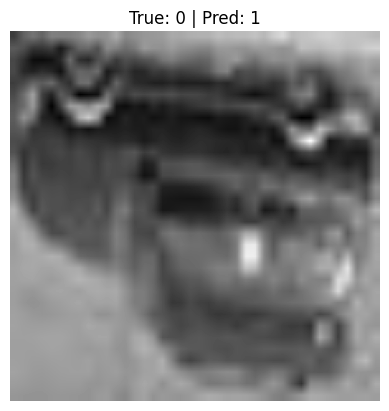

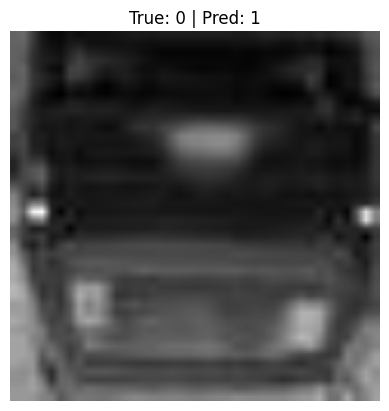

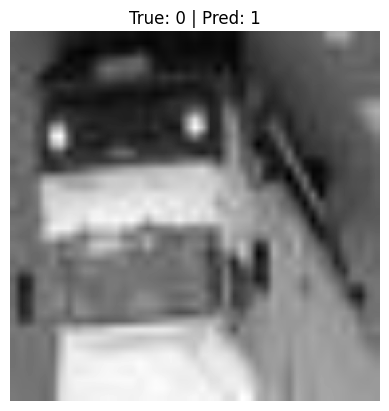

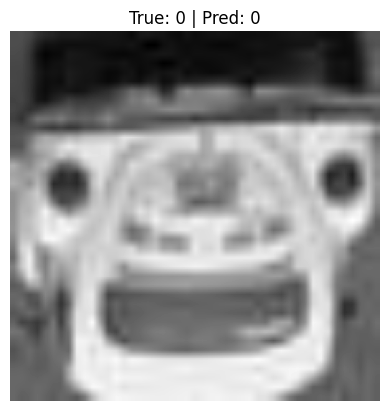

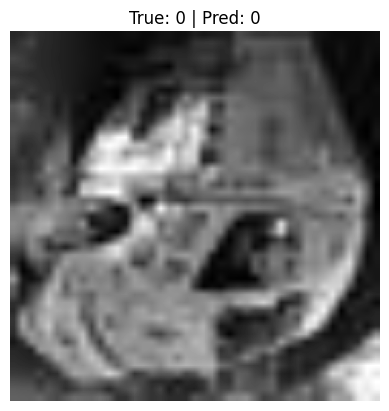

In [113]:
import matplotlib.pyplot as plt

# Parcourir le dataset pour visualisation
for images, labels in test_dataset.take(1):  # Prendre un batch
    for i in range(5):  # Afficher les 5 premières images
        plt.imshow(images[i].numpy().squeeze(), cmap="gray")
        plt.title(f"True: {np.argmax(labels[i].numpy())} | Pred: {predicted_classes[i]}")
        plt.axis("off")
        plt.show()
